# EDA🔎 and baseline with Lightning⚡Flash & DeepLab-v3 & albumentations

see: https://lightning-flash.readthedocs.io/en/stable/reference/semantic_segmentation.html

In [1]:
!pip uninstall -y torchtext
# !pip install -q --upgrade torch torchvision
!pip install -q "lightning-flash[image]" "torchmetrics<0.8" --no-index --find-links ../input/demo-flash-semantic-segmentation/frozen_packages
!pip install -q -U timm segmentation-models-pytorch --no-index --find-links ../input/demo-flash-semantic-segmentation/frozen_packages
!pip install -q 'kaggle-imsegm' --no-index --find-links ../input/tract-segm-eda-3d-interactive-viewer/frozen_packages

! pip list | grep torch
! pip list | grep lightning
! nvidia-smi -L

Found existing installation: torchtext 0.10.1
Uninstalling torchtext-0.10.1:
  Successfully uninstalled torchtext-0.10.1
efficientnet-pytorch                  0.6.3
pytorch-ignite                        0.4.8
pytorch-lightning                     1.5.10
segmentation-models-pytorch           0.2.1
torch                                 1.9.1
torchaudio                            0.9.1
torchmetrics                          0.6.2
torchvision                           0.10.1
lightning-bolts                       0.5.0
lightning-flash                       0.7.3
pytorch-lightning                     1.5.10
GPU 0: Tesla P100-PCIE-16GB (UUID: GPU-5225cf5b-1464-f9fc-a916-4e13f1729a0e)


In [2]:
import os, glob
import pandas as pd
import matplotlib.pyplot as plt

DATASET_FOLDER = "/kaggle/input/uw-madison-gi-tract-image-segmentation"
df_train = pd.read_csv(os.path.join(DATASET_FOLDER, "train.csv"))
display(df_train.head())

,id,class,segmentation
0,case123_day20_slice_0001,large_bowel,NaN
1,case123_day20_slice_0001,small_bowel,NaN
2,case123_day20_slice_0001,stomach,NaN
3,case123_day20_slice_0002,large_bowel,NaN
4,case123_day20_slice_0002,small_bowel,NaN


In [3]:
all_imgs = glob.glob(os.path.join(DATASET_FOLDER, "train", "case*", "case*_day*", "scans", "*.png"))
all_imgs = [p.replace(DATASET_FOLDER, "") for p in all_imgs]

print(f"images: {len(all_imgs)}")
print(f"annotated: {len(df_train['id'].unique())}")

images: 38496
annotated: 38496


## 🔎 Explore and enrich dataset

Take the input train table and parse some additiona informations

In [4]:
from pprint import pprint
from kaggle_imsegm.data import extract_tract_details

pprint(extract_tract_details(df_train['id'].iloc[0], DATASET_FOLDER))

df_train[['Case','Day','Slice', 'image', 'image_path', 'height', 'width']] = df_train['id'].apply(
    lambda x: pd.Series(extract_tract_details(x, DATASET_FOLDER))
)
display(df_train.head())

{'Case': 123,
 'Day': 20,
 'Slice': '0001',
 'height': 266,
 'image': 'slice_0001_266_266_1.50_1.50.png',
 'image_path': 'train/case123/case123_day20/scans/slice_0001_266_266_1.50_1.50.png',
 'width': 266}


,id,class,segmentation,Case,Day,Slice,image,image_path,height,width
0,case123_day20_slice_0001,large_bowel,NaN,123,20,0001,slice_0001_266_266_1.50_1.50.png,train/case123/case123_day20/scans/slice_0001_2...,266,266
1,case123_day20_slice_0001,small_bowel,NaN,123,20,0001,slice_0001_266_266_1.50_1.50.png,train/case123/case123_day20/scans/slice_0001_2...,266,266
2,case123_day20_slice_0001,stomach,NaN,123,20,0001,slice_0001_266_266_1.50_1.50.png,train/case123/case123_day20/scans/slice_0001_2...,266,266
3,case123_day20_slice_0002,large_bowel,NaN,123,20,0002,slice_0002_266_266_1.50_1.50.png,train/case123/case123_day20/scans/slice_0002_2...,266,266
4,case123_day20_slice_0002,small_bowel,NaN,123,20,0002,slice_0002_266_266_1.50_1.50.png,train/case123/case123_day20/scans/slice_0002_2...,266,266


Compare timeseries and stack sizes

## Browse the 3D image

see the full version (without importing own package) in https://www.kaggle.com/code/jirkaborovec/tract-segm-eda-3d-data-browser

In [5]:
from ipywidgets import interact, IntSlider
from kaggle_imsegm.data import load_volume_from_images, create_tract_segm
from kaggle_imsegm.visual import show_tract_volume

CASE = 108
DAY = 10
IMAGE_FOLDER = os.path.join(DATASET_FOLDER, "train", f"case{CASE}", f"case{CASE}_day{DAY}", "scans")
vol = load_volume_from_images(img_dir=IMAGE_FOLDER)
print(vol.shape)

df_ = df_train[(df_train["Case"] == CASE) & (df_train["Day"] == DAY)]
segm = create_tract_segm(df_vol=df_, vol_shape=vol.shape)

def interactive_show(volume):
    vol_shape = volume.shape
    interact(
        lambda x, y, z: plt.show(show_tract_volume(volume, segm, z, y, x)),
        z=IntSlider(min=0, max=vol_shape[0], step=5, value=int(vol_shape[0] / 2)),
        y=IntSlider(min=0, max=vol_shape[1], step=5, value=int(vol_shape[1] / 2)),
        x=IntSlider(min=0, max=vol_shape[2], step=5, value=int(vol_shape[2] / 2)),
    )

(144, 266, 266)


In [6]:
interactive_show(vol)

interactive(children=(IntSlider(value=133, description='x', max=266, step=5), IntSlider(value=133, description…

## Prepare flatten dataset

In [7]:
DATASET_IMAGES = "/kaggle/temp/dataset-flash/images"
DATASET_SEGMS = "/kaggle/temp/dataset-flash/segms"

for rdir in (DATASET_IMAGES, DATASET_SEGMS):
    for sdir in ("train", "val"):
        os.makedirs(os.path.join(rdir, sdir), exist_ok=True)

In [8]:
df_train['Case_Day'] = [f"case{r['Case']}_day{r['Day']}" for _, r in df_train.iterrows()]

CASES_DAYS = list(df_train['Case_Day'].unique())
VAL_SPLIT = 0.1
VAL_CASES_DAYS = CASES_DAYS[-int(VAL_SPLIT * len(CASES_DAYS)):]

print(f"all case-day: {len(CASES_DAYS)}")
print(f"val case-day: {len(VAL_CASES_DAYS)}")

all case-day: 274
val case-day: 27


In [9]:
import numpy as np
from PIL import Image
from joblib import Parallel, delayed
from kaggle_imsegm.data import preprocess_tract_scan

LABELS = sorted(df_train["class"].unique())
print(LABELS)

def _chose_sfolder(df_, val_cases_days=VAL_CASES_DAYS) -> str:
    case, day = df_.iloc[0][["Case", "Day"]]
    case_day = f"case{case}_day{day}"
    return 'val' if case_day in val_cases_days else 'train'

['large_bowel', 'small_bowel', 'stomach']


In [10]:
from tqdm.auto import tqdm

_args = dict(
    dir_data=os.path.join(DATASET_FOLDER, "train"),
    dir_imgs=DATASET_IMAGES,
    dir_segm=DATASET_SEGMS,
    labels=LABELS,
)
df_train["Case_Day"] = [f"case{r['Case']}_day{r['Day']}" for _, r in df_train.iterrows()]
_= Parallel(n_jobs=6)(
    delayed(preprocess_tract_scan)(dfg, sfolder=_chose_sfolder(dfg), **_args)
    for _, dfg in tqdm(df_train.groupby("Case_Day"))
)

  0%|          | 0/274 [00:00<?, ?it/s]

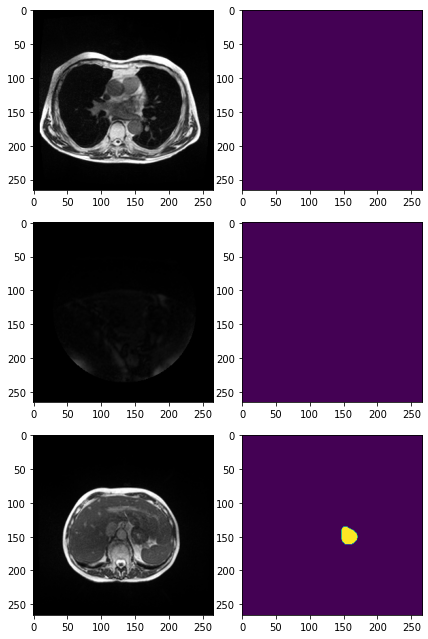

In [11]:
spl_imgs = glob.glob(os.path.join(DATASET_IMAGES, "*", "*.png"))[:3]
fig, axarr = plt.subplots(ncols=2, nrows=len(spl_imgs), figsize=(6, 3 * len(spl_imgs)))

for i, img in enumerate(spl_imgs):
    segm = img.replace(DATASET_IMAGES, DATASET_SEGMS)
    axarr[i, 0].imshow(plt.imread(img))
    axarr[i, 1].imshow(plt.imread(segm))
plt.tight_layout()

## Lightning⚡Flash

lets follow the Semantinc segmentation example: https://lightning-flash.readthedocs.io/en/stable/reference/semantic_segmentation.html

In [12]:
import torch

import flash
from flash.core.data.utils import download_data
from flash.image import SemanticSegmentation, SemanticSegmentationData

### 1. Create the DataModule

In [13]:
from dataclasses import dataclass
from typing import Any, Callable, Dict, Mapping, Sequence, Tuple, Union
import albumentations as alb
from flash.core.data.io.input_transform import InputTransform
from flash.image.segmentation.input_transform import prepare_target, remove_extra_dimensions
from kaggle_imsegm.augment import FlashAlbumentationsAdapter

@dataclass
class SemanticSegmentationInputTransform(InputTransform):
    # https://albumentations.ai/docs/examples/pytorch_semantic_segmentation

    image_size: Tuple[int, int] = (128, 128)

    def train_per_sample_transform(self) -> Callable:
        return FlashAlbumentationsAdapter([
            alb.Resize(*self.image_size),
            alb.VerticalFlip(p=0.5),
            alb.HorizontalFlip(p=0.5),
            alb.RandomRotate90(p=0.5),
            alb.ShiftScaleRotate(shift_limit=0.1, scale_limit=0.05, rotate_limit=15, p=0.5),
            alb.GaussNoise(var_limit=(0.00, 0.03), mean=0, per_channel=False, p=1.0),
            #alb.ElasticTransform(p=1, alpha=120, sigma=120 * 0.05, alpha_affine=120 * 0.03)
            #alb.RGBShift(r_shift_limit=25, g_shift_limit=25, b_shift_limit=25, p=0.5),
            #alb.RandomBrightnessContrast(brightness_limit=0.3, contrast_limit=0.3, p=0.5),
        ])

    def per_sample_transform(self) -> Callable:
        return FlashAlbumentationsAdapter([alb.Resize(*self.image_size)])

    def predict_input_per_sample_transform(self) -> Callable:
        return FlashAlbumentationsAdapter([alb.Resize(*self.image_size)])

    def target_per_batch_transform(self) -> Callable:
        return prepare_target

    def predict_per_batch_transform(self) -> Callable:
        return remove_extra_dimensions

    def serve_per_batch_transform(self) -> Callable:
        return remove_extra_dimensions

In [14]:
datamodule = SemanticSegmentationData.from_folders(
    train_folder=os.path.join(DATASET_IMAGES, 'train'),
    train_target_folder=os.path.join(DATASET_SEGMS, 'train'),
    val_folder=os.path.join(DATASET_IMAGES, 'val'),
    val_target_folder=os.path.join(DATASET_SEGMS, 'val'),
    #val_split=0.1,
    train_transform=SemanticSegmentationInputTransform,
    val_transform=SemanticSegmentationInputTransform,
    # predict_transform=SemanticSegmentationInputTransform,
    transform_kwargs=dict(image_size=(256, 256)),
    num_classes=len(LABELS) + 1,
    batch_size=24,
    num_workers=3,
)

/opt/conda/lib/python3.7/site-packages/torch/utils/data/dataloader.py:481: UserWarning: This DataLoader will create 3 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


dict_keys([<DataKeys.INPUT: 'input'>, <DataKeys.TARGET: 'target'>, <DataKeys.METADATA: 'metadata'>])


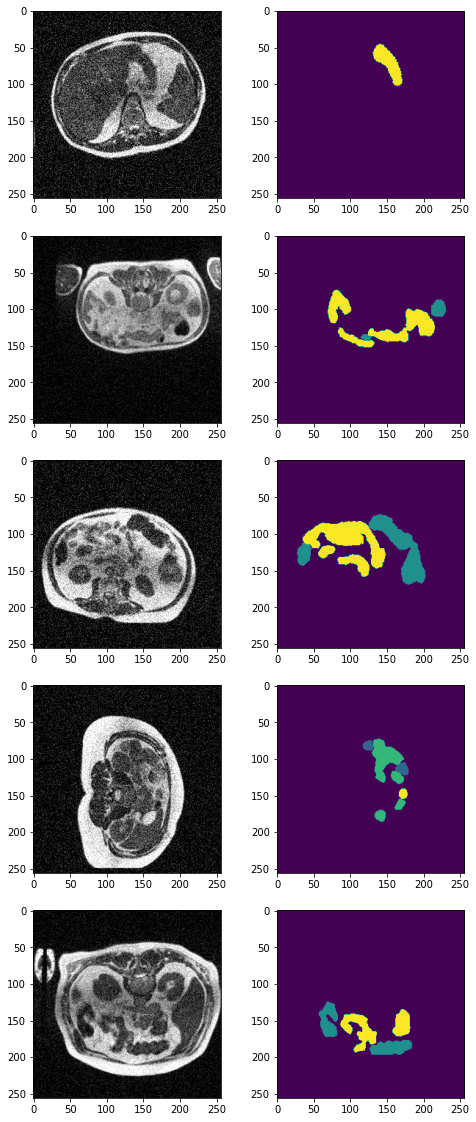

In [15]:
# datamodule.show_train_batch()

fig, axarr = plt.subplots(ncols=2, nrows=5, figsize=(8, 20))
running_i = 0

for batch in datamodule.train_dataloader():
    print(batch.keys())
    for i in range(len(batch['input'])):
        segm = batch['target'][i].numpy()
        if np.sum(segm) == 0 or np.max(segm) <= 1:
            continue
        img = np.rollaxis(batch['input'][i].cpu().numpy(), 0, 3)
        axarr[running_i, 0].imshow(img)
        axarr[running_i, 1].imshow(segm)
        running_i += 1
        if running_i >= 5:
            break
    if running_i >= 5:
        break

### 2. Build the task

In [16]:
model = SemanticSegmentation(
    backbone="resnext50_32x4d",
    head="deeplabv3",
    pretrained=False,
    optimizer="AdamW",
    learning_rate=7e-3,
    num_classes=datamodule.num_classes,
)

### 3. Create the trainer and finetune the model

In [17]:
import pytorch_lightning as pl

logger = pl.loggers.CSVLogger(save_dir='logs/')
trainer = flash.Trainer(
    max_epochs=10,
    logger=logger,
    # precision=16,
    gpus=torch.cuda.device_count(),
#     limit_train_batches=0.2,
#     limit_val_batches=0.2,
)

In [18]:
# Train the model
trainer.finetune(model, datamodule=datamodule, strategy="no_freeze")

# Save the model!
trainer.save_checkpoint("semantic_segmentation_model.pt")

/opt/conda/lib/python3.7/site-packages/flash/core/trainer.py:210: UserWarning: The model contains a default finetune callback.
  warnings.warn("The model contains a default finetune callback.", UserWarning)


Validation sanity check: 0it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

,train_iou_step,train_cross_entropy_step,val_iou,val_cross_entropy,train_iou_epoch,train_cross_entropy_epoch
epoch,,,,,,
0,0.246491,0.063837,NaN,NaN,NaN,NaN
0,0.244130,0.100328,NaN,NaN,NaN,NaN
0,0.244196,0.084023,NaN,NaN,NaN,NaN
0,0.246685,0.058118,NaN,NaN,NaN,NaN
0,0.246609,0.059357,NaN,NaN,NaN,NaN


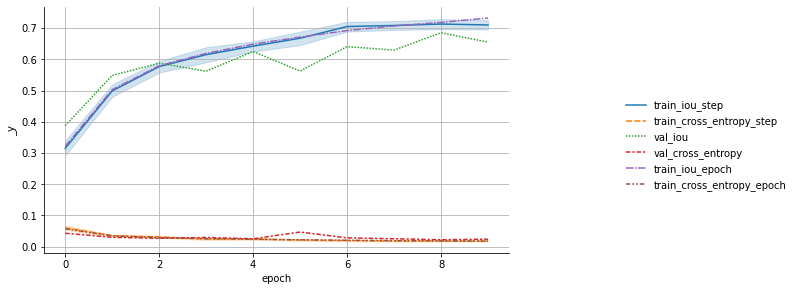

In [19]:
import seaborn as sn

metrics = pd.read_csv(f'{trainer.logger.log_dir}/metrics.csv')
del metrics["step"]
metrics.set_index("epoch", inplace=True)
display(metrics.dropna(axis=1, how="all").head())
g = sn.relplot(data=metrics, kind="line")
plt.gcf().set_size_inches(12, 4)
plt.grid()

### 4. Segment a few images!

In [20]:
sample_imgs = glob.glob(os.path.join(DATASET_FOLDER, "test", "**", "*.png"), recursive=True)
if not sample_imgs:
    sample_imgs = glob.glob(os.path.join(DATASET_FOLDER, "train", "**", "*.png"), recursive=True)
print(f"images: {len(sample_imgs)}")
sample_imgs = sample_imgs[:5]

datamodule = SemanticSegmentationData.from_files(
    predict_files=sample_imgs,
    predict_transform=SemanticSegmentationInputTransform,
    transform_kwargs=dict(image_size=(256, 256)),
    batch_size=3,
)

images: 38496


Predicting: 1442it [00:00, ?it/s]

/opt/conda/lib/python3.7/site-packages/torch/nn/functional.py:3613: UserWarning: Default upsampling behavior when mode=bilinear is changed to align_corners=False since 0.4.0. Please specify align_corners=True if the old behavior is desired. See the documentation of nn.Upsample for details.
  "See the documentation of nn.Upsample for details.".format(mode)


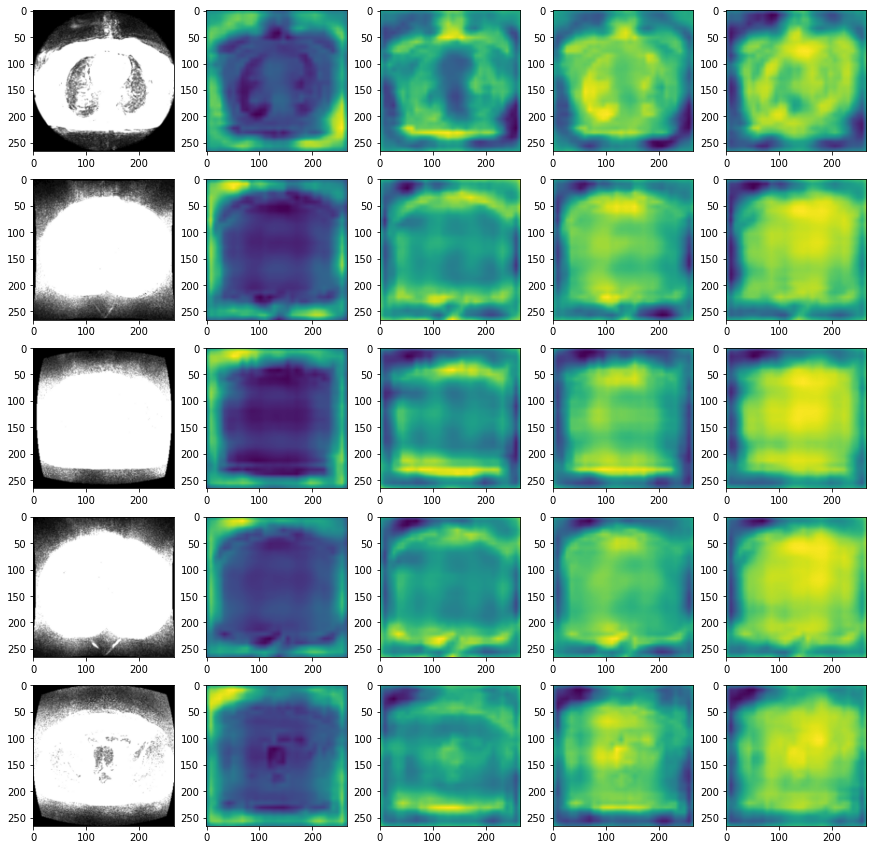

In [21]:
fig, axarr = plt.subplots(ncols=5, nrows=len(sample_imgs), figsize=(15, 3 * len(sample_imgs)))
running_i = 0
for preds in trainer.predict(model, datamodule=datamodule):
    for pred in preds:
        # print(pred.keys())
        img = np.rollaxis(pred['input'].cpu().numpy(), 0, 3)
        axarr[running_i, 0].imshow(img)
        for j, seg in enumerate(pred['preds'].cpu().numpy()):
            axarr[running_i, j + 1].imshow(seg)
        running_i += 1

/opt/conda/lib/python3.7/site-packages/pytorch_lightning/core/datamodule.py:470: LightningDeprecationWarning: DataModule.setup has already been called, so it will not be called again. In v1.6 this behavior will change to always call DataModule.setup.
  f"DataModule.{name} has already been called, so it will not be called again. "


Predicting: 1442it [00:00, ?it/s]

/opt/conda/lib/python3.7/site-packages/pytorch_lightning/core/datamodule.py:470: LightningDeprecationWarning: DataModule.teardown has already been called, so it will not be called again. In v1.6 this behavior will change to always call DataModule.teardown.
  f"DataModule.{name} has already been called, so it will not be called again. "


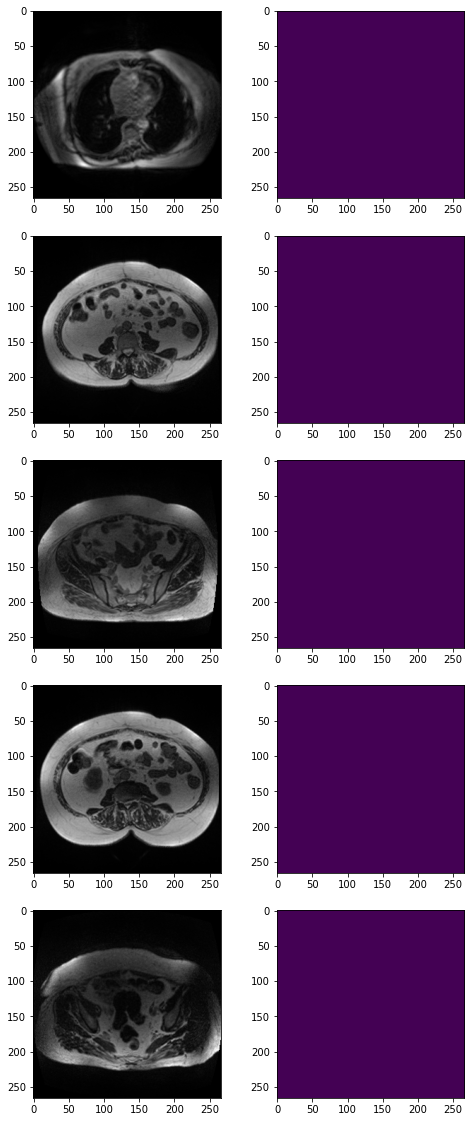

In [22]:
fig, axarr = plt.subplots(ncols=2, nrows=len(sample_imgs), figsize=(8, 4 * len(sample_imgs)))
running_i = 0
for preds in trainer.predict(model, datamodule=datamodule, output="labels"):
    for pred in preds:
        # print(pred)
        img = plt.imread(sample_imgs[running_i])
        axarr[running_i, 0].imshow(img, cmap="gray")
        axarr[running_i, 1].imshow(pred)
        running_i += 1

# Inference

In [23]:
model = SemanticSegmentation.load_from_checkpoint(
    "semantic_segmentation_model.pt"
)

In [24]:
df_pred = pd.read_csv(os.path.join(DATASET_FOLDER, "sample_submission.csv"))
sfolder = "test"
display(df_pred.head())

if df_pred.empty:
    sfolder = "train"
    df_pred = pd.read_csv(os.path.join(DATASET_FOLDER, "train.csv"))
    df_pred = df_pred[df_pred["id"].str.startswith("case123_day")]

os.makedirs(os.path.join(DATASET_IMAGES, sfolder), exist_ok=True)

,id,class,predicted


In [25]:
from pprint import pprint
from kaggle_imsegm.data import extract_tract_details

pprint(extract_tract_details(df_pred['id'].iloc[0], DATASET_FOLDER, folder=sfolder))

df_pred[['Case','Day','Slice', 'image', 'image_path', 'height', 'width']] = df_pred['id'].apply(
    lambda x: pd.Series(extract_tract_details(x, DATASET_FOLDER, folder=sfolder))
)
df_pred["Case_Day"] = [f"case{r['Case']}_day{r['Day']}" for _, r in df_pred.iterrows()]
display(df_pred.head())

{'Case': 123,
 'Day': 20,
 'Slice': '0001',
 'height': 266,
 'image': 'slice_0001_266_266_1.50_1.50.png',
 'image_path': 'train/case123/case123_day20/scans/slice_0001_266_266_1.50_1.50.png',
 'width': 266}


,id,class,segmentation,Case,Day,Slice,image,image_path,height,width,Case_Day
0,case123_day20_slice_0001,large_bowel,NaN,123,20,0001,slice_0001_266_266_1.50_1.50.png,train/case123/case123_day20/scans/slice_0001_2...,266,266,case123_day20
1,case123_day20_slice_0001,small_bowel,NaN,123,20,0001,slice_0001_266_266_1.50_1.50.png,train/case123/case123_day20/scans/slice_0001_2...,266,266,case123_day20
2,case123_day20_slice_0001,stomach,NaN,123,20,0001,slice_0001_266_266_1.50_1.50.png,train/case123/case123_day20/scans/slice_0001_2...,266,266,case123_day20
3,case123_day20_slice_0002,large_bowel,NaN,123,20,0002,slice_0002_266_266_1.50_1.50.png,train/case123/case123_day20/scans/slice_0002_2...,266,266,case123_day20
4,case123_day20_slice_0002,small_bowel,NaN,123,20,0002,slice_0002_266_266_1.50_1.50.png,train/case123/case123_day20/scans/slice_0002_2...,266,266,case123_day20


## Predictions for test scans

In [26]:
from joblib import Parallel, delayed
from kaggle_imsegm.data import preprocess_tract_scan

_args = dict(
    dir_data=os.path.join(DATASET_FOLDER, sfolder),
    dir_imgs=DATASET_IMAGES,
    dir_segm=None,
    labels=LABELS,
    sfolder=sfolder,
)
test_scans = Parallel(n_jobs=6)(
    delayed(preprocess_tract_scan)(dfg, **_args)
    for _, dfg in df_pred.groupby("Case_Day")
)

In [27]:
import numpy as np
from itertools import chain
from kaggle_imsegm.mask import rle_encode

preds = []
for test_imgs in test_scans:
    dm = SemanticSegmentationData.from_files(
        predict_files=test_imgs,
        predict_transform=SemanticSegmentationInputTransform,
        transform_kwargs=dict(image_size=(256, 256)),
        num_classes=len(LABELS) + 1,
        batch_size=10,
        num_workers=3,
    )
    pred = trainer.predict(model, datamodule=dm, output="labels")
    pred = list(chain(*pred))
    for img, seg in zip(test_imgs, pred):
        rle = rle_encode(np.array(seg)) if np.sum(seg) > 1 else {}
        name, _ = os.path.splitext(os.path.basename(img))
        id_ = "_".join(name.split("_")[:4])
        preds += [{"id": id_, "class": lb, "predicted": rle.get(i + 1, "")} for i, lb in enumerate(LABELS)]

df_pred = pd.DataFrame(preds)
display(df_pred[df_pred["predicted"] != ""].head())

/opt/conda/lib/python3.7/site-packages/torch/utils/data/dataloader.py:481: UserWarning: This DataLoader will create 3 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


Predicting: 1442it [00:00, ?it/s]

/opt/conda/lib/python3.7/site-packages/torch/nn/functional.py:3613: UserWarning: Default upsampling behavior when mode=bilinear is changed to align_corners=False since 0.4.0. Please specify align_corners=True if the old behavior is desired. See the documentation of nn.Upsample for details.
  "See the documentation of nn.Upsample for details.".format(mode)


Predicting: 1442it [00:00, ?it/s]

Predicting: 1442it [00:00, ?it/s]

,id,class,predicted
146,case123_day0_slice_0049,stomach,29689 3 29700 7 29954 4 29969 3 30220 4 30486 ...
149,case123_day0_slice_0050,stomach,28891 2 29155 10 29420 12 29685 14 29950 16 30...
152,case123_day0_slice_0051,stomach,27295 1 27560 4 27825 7 28091 9 28356 12 28621...
155,case123_day0_slice_0052,stomach,26230 9 26495 11 26760 13 27026 14 27291 15 27...
158,case123_day0_slice_0053,stomach,24376 2 24639 5 24902 9 25167 10 25432 11 2569...


## Finalize submissions

In [28]:
df_ssub = pd.read_csv(os.path.join(DATASET_FOLDER, "sample_submission.csv"))
del df_ssub['predicted']
df_pred = df_ssub.merge(df_pred, on=['id','class'])

df_pred[['id', 'class', 'predicted']].to_csv("submission.csv", index=False)

!head submission.csv

id,class,predicted
